# Import libraries

In [1]:
import os

# Dataset loading

In [2]:
print(os.listdir("/kaggle/input"))

['models', 'sport-dataset']


In [3]:
import shutil
from distutils.dir_util import copy_tree

dataset_name = "sport-dataset"
input_path = f"/kaggle/input/{dataset_name}"

# loading into temp memory
fast_path = "/kaggle/temp/data"

# copying data
if not os.path.exists(fast_path):
    print("Starting...")
    shutil.copytree(input_path, fast_path)
    print("Completed")
else:
    print(f"data are already in: {fast_path}")

print(f"Data loaded into: {os.listdir(fast_path)}")

Starting...
Completed
Data loaded into: ['exam_dataset']


In [4]:
# exploring subdirectories
directories = []
for root, dirs, files in os.walk(fast_path):
    if len(dirs) > 1:
        print(f"Dataset in: {root}")
        print(f"Directories: {dirs}")
        directories = dirs.copy()
        print(f"Files: {files}")
        dataset_root = root
        break

TRAINING_ROOT = dataset_root + ('/' + directories[-1])*2
VALIDATION_ROOT = dataset_root + ('/' + directories[0])*2
TEST_ROOT = dataset_root + ('/' + directories[2])*2
TEST_DEGRADATO_ROOT = dataset_root + ('/' + directories[1])*2

Dataset in: /kaggle/temp/data/exam_dataset
Directories: ['valid', 'test_degradato', 'test', 'train']
Files: ['sports_labels.csv']


## Keras dataset creation

In [5]:
import tensorflow as tf
import keras
keras.backend.clear_session()

keras.utils.set_random_seed(42)

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_ROOT,
    image_size=(299, 299),
    batch_size=32,
    label_mode='categorical',
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_ROOT,
    image_size=(299, 299),
    batch_size=32,
    label_mode='categorical',
    crop_to_aspect_ratio=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_ROOT,
    image_size=(299, 299),
    batch_size=32,
    label_mode='categorical',
    crop_to_aspect_ratio=True
)

test_degradato_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DEGRADATO_ROOT,
    image_size=(299, 299),
    batch_size=32,
    label_mode='categorical',
    crop_to_aspect_ratio=True
)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_degradato_ds = test_degradato_ds.cache().prefetch(buffer_size=AUTOTUNE)

2026-02-19 09:00:25.738012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771491625.917363      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771491625.972183      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771491626.411414      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771491626.411459      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771491626.411462      55 computation_placer.cc:177] computation placer alr

Found 13492 files belonging to 100 classes.


I0000 00:00:1771491639.746201      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


# Useful functions

In [6]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label='Training Acc')
    plt.plot(epochs, val_acc, label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()


def get_soft_augmentation():
    return keras.Sequential([
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(factor=0.05, fill_mode="reflect"),
        keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="reflect"),
        keras.layers.RandomZoom(height_factor=0.1, width_factor=None, fill_mode="reflect"),
        keras.layers.RandomContrast(factor=0.1),       
    ], name="Soft_Augmentation")

def get_task2_augmentation():
    return keras.Sequential([
        # --- Augmentation SPAZIALE (Nuova e fondamentale) ---
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(factor=0.1), # Ruota del +/- 10%
        keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
        
        # --- La tua Augmentation sui COLORI (Mantenuta) ---
        keras.layers.RandomBrightness(factor=0.3),
        keras.layers.RandomContrast(factor=0.3),
        keras.layers.RandomColorJitter(brightness_factor=0.2, contrast_factor=0.2, saturation_factor=0.3, hue_factor=0.1),
    ], name="augmentation_pipeline")

# Task 1 CNN

In [7]:
def get_simple_cnn(num_classes):
    model = keras.Sequential([
        keras.layers.Input(shape=(299, 299, 3)),
        
        # normalization
        keras.layers.Rescaling(1./255), 
        
        get_soft_augmentation(),
        
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L2(1e-3)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L2(1e-3)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation='softmax')
    ], name="Simple_CNN")
    return model

mycnn_task1 = get_simple_cnn(num_classes=100) 

mycnn_task1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-5),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')]
)

mycnn_task1.summary()

Model: "Simple_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Soft_Augmentation (Sequential)  │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 299, 299, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 149, 149, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 501,924 (1.91 MB)

 Trainable params: 500,964 (1.91 MB)

 Non-trainable params: 960 (3.75 KB)

In [8]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=6,
    min_lr=1e-6,
)

history_mycnn_task1 = mycnn_task1.fit(x=train_ds, validation_data=val_ds, epochs=80, callbacks=[reduce_lr])

Epoch 1/80


I0000 00:00:1771491665.823913     128 cuda_dnn.cc:529] Loaded cuDNN version 91002


422/422 ━━━━━━━━━━━━━━━━━━━━ 85s 139ms/step - accuracy: 0.0206 - loss: 5.0072 - top5_acc: 0.0937 - val_accuracy: 0.0660 - val_loss: 4.3812 - val_top5_acc: 0.2220 - learning_rate: 0.0010
Epoch 2/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 57s 136ms/step - accuracy: 0.0611 - loss: 4.4257 - top5_acc: 0.2242 - val_accuracy: 0.0680 - val_loss: 4.3532 - val_top5_acc: 0.2300 - learning_rate: 0.0010
Epoch 3/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 57s 136ms/step - accuracy: 0.0852 - loss: 4.1239 - top5_acc: 0.2916 - val_accuracy: 0.1140 - val_loss: 3.8810 - val_top5_acc: 0.3480 - learning_rate: 0.0010
Epoch 4/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 57s 136ms/step - accuracy: 0.1053 - loss: 3.9089 - top5_acc: 0.3497 - val_accuracy: 0.1340 - val_loss: 3.6880 - val_top5_acc: 0.3860 - learning_rate: 0.0010
Epoch 5/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 57s 136ms/step - accuracy: 0.1412 - loss: 3.6924 - top5_acc: 0.4111 - val_accuracy: 0.0940 - val_loss: 4.2666 - val_top5_acc: 0.3160 - learning_rate: 0.0010
Epoch 6/80
422/422 ━━━━━━━

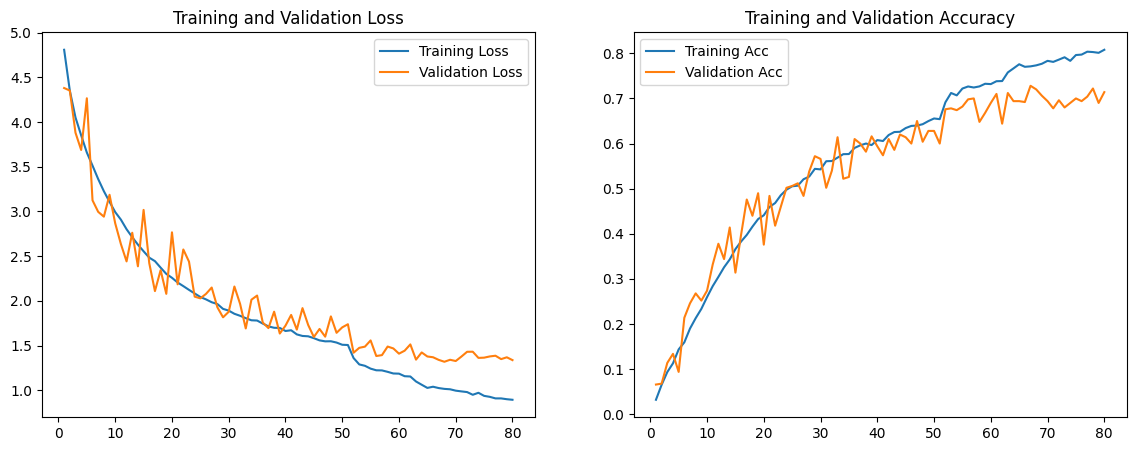

In [11]:
plot_history(history_mycnn_task1)

In [10]:
mycnn_task1.save("mymodel_task1.keras")

In [12]:
_, accuracy, top5_accuracy = mycnn_task1.evaluate(test_ds)
print("="*30)
print("Valutazione test set")
print(f"accuracy {accuracy}")
print(f"top 5 accuracy {top5_accuracy}")

print("\n\n")

_, accuracy, top5_accuracy = mycnn_task1.evaluate(test_degradato_ds)
print("="*30)
print("Valutazione test set degradato")
print(f"accuracy {accuracy}")
print(f"top 5 accuracy {top5_accuracy}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7274 - loss: 1.2797 - top5_acc: 0.9373
Valutazione test set
accuracy 0.7440000176429749
top 5 accuracy 0.9380000233650208



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3888 - loss: 3.7350 - top5_acc: 0.6619
Valutazione test set degradato
accuracy 0.4059999883174896
top 5 accuracy 0.6700000166893005


# Task 2 CNN

In [15]:
def get_simple_cnn(num_classes):
    model = keras.Sequential([
        keras.layers.Input(shape=(299, 299, 3)),
        
        get_task2_augmentation(), 
        
        # normalization [0, 1]
        keras.layers.Rescaling(1./255), 
        
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.BatchNormalization(), 
        
        keras.layers.Dense(512, use_bias=False), # bias managed by batchnormalization 
        keras.layers.BatchNormalization(),       # batchnormalization befor ReLU
        keras.layers.Activation('relu'),         
        keras.layers.Dropout(0.4),               
        keras.layers.Dense(num_classes, activation='softmax')
    ], name="Simple_CNN")
    return model

mymodel_task2 = get_simple_cnn(num_classes=100) 

mymodel_task2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')]
)

mymodel_task2.summary()

Model: "Simple_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_pipeline           │ (None, 299, 299, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 299, 299, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 149, 149, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 149, 149, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 74, 74, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 74, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 37, 37, 512)    │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 37, 37, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,30

 Total params: 1,003,332 (3.83 MB)

 Trainable params: 999,812 (3.81 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [16]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # Dividi per 2 invece che per 5 (meno traumatico)
    patience=5,       # Aspetta un attimo prima di tagliare
    min_lr=1e-6,
    verbose=1
)

history_mymodel_task2 = mymodel_task2.fit(x=train_ds, validation_data=val_ds, epochs=80, callbacks=[reduce_lr])

Epoch 1/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 70s 154ms/step - accuracy: 0.0303 - loss: 4.7719 - top5_acc: 0.1205 - val_accuracy: 0.0260 - val_loss: 5.7213 - val_top5_acc: 0.0960 - learning_rate: 0.0010
Epoch 2/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 64s 151ms/step - accuracy: 0.0678 - loss: 4.1269 - top5_acc: 0.2426 - val_accuracy: 0.1000 - val_loss: 3.9380 - val_top5_acc: 0.3280 - learning_rate: 0.0010
Epoch 3/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 64s 151ms/step - accuracy: 0.1046 - loss: 3.8667 - top5_acc: 0.3121 - val_accuracy: 0.0920 - val_loss: 4.1739 - val_top5_acc: 0.3300 - learning_rate: 0.0010
Epoch 4/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 64s 151ms/step - accuracy: 0.1369 - loss: 3.5793 - top5_acc: 0.3903 - val_accuracy: 0.1240 - val_loss: 4.1582 - val_top5_acc: 0.4320 - learning_rate: 0.0010
Epoch 5/80
422/422 ━━━━━━━━━━━━━━━━━━━━ 64s 151ms/step - accuracy: 0.1899 - loss: 3.2800 - top5_acc: 0.4838 - val_accuracy: 0.1420 - val_loss: 3.7186 - val_top5_acc: 0.4460 - learning_rate: 0.0010
Epoch 6/80
422/

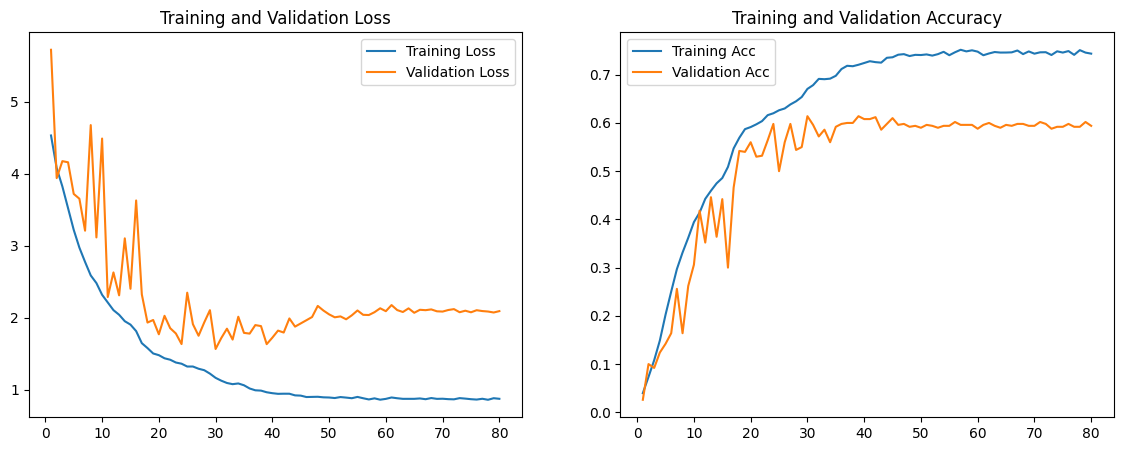

In [17]:
plot_history(history_mymodel_task2)

In [19]:
mymodel_task2.save("mymodel_task2.keras")

In [20]:
_, accuracy, top5_accuracy = mymodel_task2.evaluate(test_degradato_ds)
print("="*30)
print("Valutazione test set degradato")
print(f"accuracy {accuracy}")
print(f"top 5 accuracy {top5_accuracy}")

_, accuracy, top5_accuracy = mymodel_task2.evaluate(test_ds)
print("="*30)
print("Valutazione test set")
print(f"accuracy {accuracy}")
print(f"top 5 accuracy {top5_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4278 - loss: 3.1263 - top5_acc: 0.7437
Valutazione test set degradato
accuracy 0.44200000166893005
top 5 accuracy 0.7379999756813049
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6445 - loss: 1.6356 - top5_acc: 0.8665
Valutazione test set
accuracy 0.6380000114440918
top 5 accuracy 0.8579999804496765


# Mini ResNet 

In [35]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    
    x = keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False, kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(filters, kernel_size, padding='same', use_bias=False, kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = keras.layers.BatchNormalization()(x)
    
    # manage different dimension for filters and stride
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = keras.layers.Conv2D(filters, (1, 1), strides=stride, padding='same', use_bias=False, kernel_regularizer=keras.regularizers.l2(1e-4))(shortcut)
        shortcut = keras.layers.BatchNormalization()(shortcut)
    
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.Activation('relu')(x)
    return x

def get_mini_resnet(num_classes):
    inputs = keras.Input(shape=(299, 299, 3))
    
    x = get_task2_augmentation()(inputs)
    x = keras.layers.Rescaling(1./255)(x)

    # stem
    x = keras.layers.Conv2D(64, (7, 7), strides=2, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    
    # block 1 
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    # block 2 
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    
    # block 3 
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.3)(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs, name="Mini_ResNet")

miniresnet_task2 = get_mini_resnet(num_classes=100)
miniresnet_task2.summary() 

callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5,       
        patience=5,       
        min_lr=1e-6, 
        verbose=1
    ),

miniresnet_task2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')]
)

Model: "Mini_ResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation_pipel… │ (None, 299, 299,  │          0 │ input_layer_10[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 299, 299,  │          0 │ augmentation_pip… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 150, 150,  │      9,408 │ rescaling_5[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │        256 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_40       │ (None, 150, 150,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 75, 75,    │          0 │ activation_40[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 75, 75,    │     36,864 │ max_pooling2d_11… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_41       │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 75, 75,    │     36,864 │ activation_41[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 75, 75,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_42       │ (None, 75, 75,    │          0 │ add_18[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 75, 75,    │     36,864 │ activation_42[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_43       │ (None, 75, 75,    │          0 │ batch_normalizat

 Total params: 2,812,964 (10.73 MB)

 Trainable params: 2,808,484 (10.71 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [36]:
history_miniresnet_task2 = miniresnet_task2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=65, 
    callbacks=callbacks_list
)

Start training Mini-ResNet...
Epoch 1/65
422/422 ━━━━━━━━━━━━━━━━━━━━ 70s 145ms/step - accuracy: 0.0192 - loss: 4.9112 - top5_acc: 0.0877 - val_accuracy: 0.0240 - val_loss: 7.9772 - val_top5_acc: 0.0940 - learning_rate: 0.0010
Epoch 2/65
422/422 ━━━━━━━━━━━━━━━━━━━━ 60s 142ms/step - accuracy: 0.0503 - loss: 4.4157 - top5_acc: 0.1865 - val_accuracy: 0.0460 - val_loss: 4.3171 - val_top5_acc: 0.2420 - learning_rate: 0.0010
Epoch 3/65
422/422 ━━━━━━━━━━━━━━━━━━━━ 60s 142ms/step - accuracy: 0.0785 - loss: 4.1611 - top5_acc: 0.2625 - val_accuracy: 0.0720 - val_loss: 4.4471 - val_top5_acc: 0.2420 - learning_rate: 0.0010
Epoch 4/65
422/422 ━━━━━━━━━━━━━━━━━━━━ 60s 142ms/step - accuracy: 0.1059 - loss: 3.9642 - top5_acc: 0.3191 - val_accuracy: 0.0540 - val_loss: 6.1226 - val_top5_acc: 0.1500 - learning_rate: 0.0010
Epoch 5/65
422/422 ━━━━━━━━━━━━━━━━━━━━ 60s 142ms/step - accuracy: 0.1491 - loss: 3.7226 - top5_acc: 0.4072 - val_accuracy: 0.0280 - val_loss: 6.7286 - val_top5_acc: 0.1260 - learnin

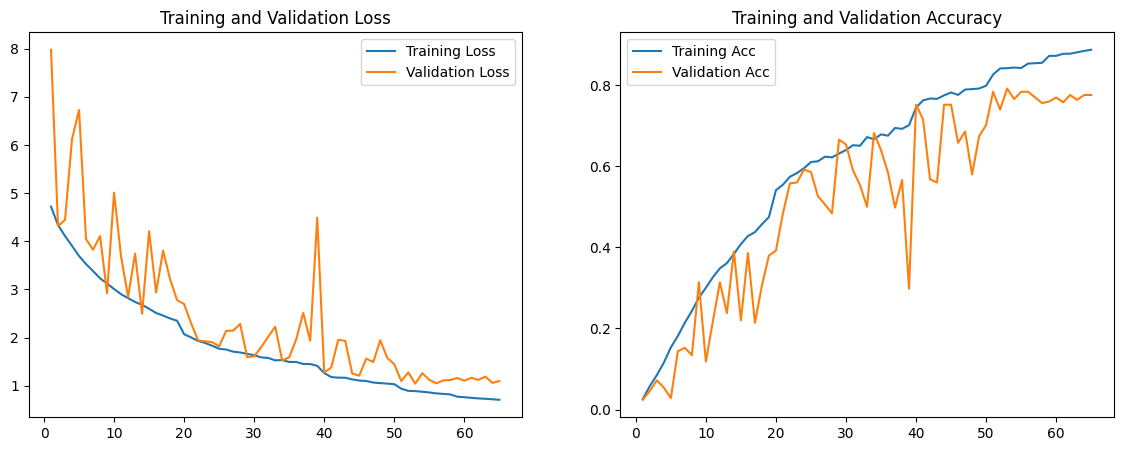

In [39]:
plot_history(history_miniresnet_task2)

In [40]:
_, accuracy, top5_accuracy = miniresnet_task2.evaluate(test_degradato_ds)
print("="*30)
print("Valutazione test set degradato")
print(f"accuracy {accuracy}")
print(f"top 5 accuracy {top5_accuracy}")

_, accuracy, top5_accuracy = miniresnet_task2.evaluate(test_ds)
print("="*30)
print("Valutazione test set")
print(f"accuracy {accuracy}")
print(f"top 5 accuracy {top5_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6578 - loss: 1.8921 - top5_acc: 0.8569
Valutazione test set degradato
accuracy 0.6639999747276306
top 5 accuracy 0.8600000143051147
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8155 - loss: 0.9314 - top5_acc: 0.9525
Valutazione test set
accuracy 0.8100000023841858
top 5 accuracy 0.9580000042915344


In [41]:
miniresnet_task2.save("miniresnet_task2.keras")